# Preprocessing

In [1]:
import pygments.lexers
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

import sys
sys.path.append('./reentrancyContracts')
sys.path.append('./reentrancyContractLabels')
import reentrancyContracts
import reentrancyContractLabels

### Extract Global Variables

In [2]:
# takes in full contract and pull out names of global variables (with reasonable accuracy)
def getGlobalVariables(contract):
    lexer = pygments.lexers.get_lexer_by_name('Solidity')
    tokens = list(pygments.lex(contract, lexer))
    globalVarList = []
    openBracketsCount = 0
    openParenthesisCount = 0
    i = 0
    while i < len(tokens):
        if str(tokens[i][0]) == 'Token.Text.Whitespace' or str(tokens[i][0]) == 'Token.Comment.Single': None
        elif(tokens[i][1] == '{'): openBracketsCount += 1
        elif(tokens[i][1] == '}'): openBracketsCount -= 1
        elif(tokens[i][1] == '('): openParenthesisCount += 1
        elif(tokens[i][1] == ')'): openParenthesisCount -= 1
        elif(str(tokens[i][0]) == 'Token.Keyword.Type' and isType(tokens[i][1]) and openBracketsCount == 1 and openParenthesisCount == 0):
            index = 0
            potentialGlobal = ""
            include = True
            while True:
                if(tokens[i+index][1] == "constant"): 
                    include = False
                if(tokens[i+index][1] == ';'):
                    if include:
                        globalVarList.append(potentialGlobal)
                    break
                if(tokens[i+index][0] == pygments.token.Name.Variable or tokens[i+index][0] == pygments.token.Text):
                    potentialGlobal = tokens[i+index][1]
                    
                index += 1
            i += (index-1)
        i += 1
        
    return globalVarList

### Extract Modifiers

In [3]:
# extracts names of modifiers (function guards) for tokenization process
def getModifiers(contract):
    lexer = pygments.lexers.get_lexer_by_name('Solidity')
    tokens = list(pygments.lex(contract, lexer))
    filteredTokens = []
    for token in tokens:
        if str(token[0]) != 'Token.Text.Whitespace':
            filteredTokens.append(token)
            
    modifierNameList = []
    openBracketsCount = 0
    openParenthesisCount = 0
    i = 0
    while i < len(filteredTokens):
        if(str(filteredTokens[i][0]) == 'Token.Keyword.Type' and str(filteredTokens[i][1]) == 'modifier'):
            modifierNameList.append(filteredTokens[i+1][1])
        
        i += 1
        
    return modifierNameList

### Extract Function Source Code

In [4]:
# given contract source code, extracts lists of basic tokens for individual functions
def getFunctions(contract):
    lexer = pygments.lexers.get_lexer_by_name('Solidity')
    tokens = list(pygments.lex(contract, lexer))
    functionList = []
    i = 0
    while i < len(tokens):
        if str(tokens[i][0]) == "Token.Keyword.Type" and tokens[i][1] == 'function':
            currFunctionNum = len(functionList)
            functionList.append([tokens[i]])
            i += 1
            
            oneLiner = False
            while tokens[i][1] != '{':
                # the one-liner case
                if str(tokens[i][1]) == ';':
                    i += 1
                    oneLiner = True
                    break
                if str(tokens[i][0]) != 'Token.Text.Whitespace' and str(tokens[i][0]) != 'Token.Comment.Single':
                    functionList[currFunctionNum].append(tokens[i])
                i += 1
                
            functionList[currFunctionNum].append(tokens[i])
            openBracketsCount = 1
            i += 1
            
            while openBracketsCount > 0:
                if(tokens[i][1] == '{'): openBracketsCount += 1
                elif(tokens[i][1] == '}'): openBracketsCount -= 1
                
                if str(tokens[i][0]) != 'Token.Text.Whitespace' and str(tokens[i][0]) != 'Token.Comment.Single':
                    functionList[currFunctionNum].append(tokens[i])
                i += 1
        else:
            i += 1
    return functionList

### Tokenize Functions

In [5]:
# given a function's basic tokenization and a list of modifier and global variable names, fully tokenize function
def tokenize(parsedFunction, globalVariablesList, modifierNameList):
    txKeywords = ['call', 'transfer', 'send']
    tokenList = []
    for tup in parsedFunction:
        if tokenList and tokenList[-1] == "function":
            tokenList.append("Token.FunctionName")
        elif str(tup[1]) in txKeywords:
            tokenList.append("Token.TxWord")
#         elif 'Token.Literal' in str(tup[0]):
#             tokenList.append("Token.Constant")
        elif tup[1] in globalVariablesList:
            tokenList.append("Token.GlobalVariable")
        elif tup[1] in modifierNameList:
            tokenList.append("Token.ModifierName")
        elif tup[1].startswith("\""):
            tokenList.append("Token.String")
        elif str(tup[0]) == 'Token.Name.Variable' or str(tup[0]) == 'Token.Text':
            tokenList.append("Token.LocalVariable")
        elif str(tup[0]) != 'Token.Text.Whitespace' and str(tup[0]) != 'Token.Comment.Single':
            tokenList.append(tup[1])
    return tokenList

In [6]:
# checks if keyword is for variable declaration (helper for global variable parser)
def isType(word):
    keywords = ['address', 'bool', 'byte', 'bytes', 'int', 'string', 'uint', 'mapping']
    for kw in keywords:
        if kw in word:
            return True
    return False

In [7]:
# processing pipeline:
# - receives contract
# - extracts list of global variable names
# - extracts list of modifier names
# - extracts list of function source code
# - creates tokenized list of functions

def tokenizeContractFunctions(contract):
    globalVariablesList = getGlobalVariables(contract)
    modifierNameList = getModifiers(contract)
    functionList = getFunctions(contract)
    
    tokenizedFunctionList = []
    for function in functionList:
        tokenizedFunction = tokenize(function, globalVariablesList, modifierNameList)
        tokenizedFunctionList.append(tokenizedFunction)
    
    return tokenizedFunctionList

### Create DataFrame (currently not in use)

In [8]:
def createTuples(tokenizedFunctions, labels):
    tuples = []
    for i in range(len(tokenizedFunctions)):
        
        tuples.append([tokenizedFunctions[i], labels[i]])
    return tuples

In [9]:
def createDataFrame(contracts, contractLabels):
    df = pd.DataFrame(columns=['tokenized_function', 'label'])
    for i in range(len(contracts)):
        tokenizedFunctions = tokenizeContractFunctions(contracts[i])
        tuples = createTuples(tokenizedFunctions, contractLabels[i])
        appendable = pd.DataFrame(tuples, columns=['tokenized_function', 'label'])
        df = df.append(appendable, ignore_index=True)
    
    return df

### Create Matching Lists of Functions and Corresponding Labels

In [10]:
def returnData(contracts, contractLabels):
    functions = []
    labels = []
    for i in range(len(contracts)):
        tokenizedFunctions = tokenizeContractFunctions(contracts[i])
        functions.extend(tokenizedFunctions)
        labels.extend(contractLabels[i])
    
    return [functions, labels]

### Create Embeddings for Tokens

In [11]:
# creates Word2Vec mapping from token to vector
def get_w2v_mapping(tokenizedFunctionsDf, token_dim):
    w2v = Word2Vec(tokenizedFunctionsDf, min_count=1, size=token_dim, workers=3, window=3, sg=1)
    return w2v

In [12]:
# given list of tokenized functions, convert into list of list of embeddings
def vectorize_functions(tokenized_functions, w2v_mapping):
    embedding_list = []
    for i in range(len(tokenized_functions)):
        embedding = []
        for token in tokenized_functions[i]:
            embedding.append(w2v_mapping[token])
        
        embedding_list.append(embedding)
    return embedding_list

In [13]:
# given list of embeddings, add padding
def pad_embeddings(embeddings, max_length, token_dim):
    padded_embeddings = []
    for embedding in embeddings:
        zero_padding_cnt = max_length - len(embedding)
        pad = np.zeros((1, token_dim))
        for i in range(zero_padding_cnt):
            embedding = np.concatenate((embedding, pad), axis=0)
        padded_embeddings.append(embedding)
    return padded_embeddings

In [14]:
# compiles Word2Vec mapping, creates embedded function representations, and applies padding
def getFunctionEmbeddings(tokenizedFunctions, max_length, token_dim):
    w2v_mapping = get_w2v_mapping(tokenizedFunctions, token_dim)
    vectorized_fns = vectorize_functions(tokenizedFunctions, w2v_mapping)
    padded_embeddings = pad_embeddings(vectorized_fns, max_length, token_dim)
    return [w2v_mapping, padded_embeddings]

In [15]:
length = 500
token_dim = 15

[functions, labels] = returnData(reentrancyContracts.contracts, reentrancyContractLabels.labels)
[w2v_mapping, fn_embeddings] = getFunctionEmbeddings(functions, length, token_dim)
fn_embeddings = np.array(fn_embeddings)
print("X shape: ", fn_embeddings.shape)

X shape:  (227, 500, 15)


### Token Visualization

In [16]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk

from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

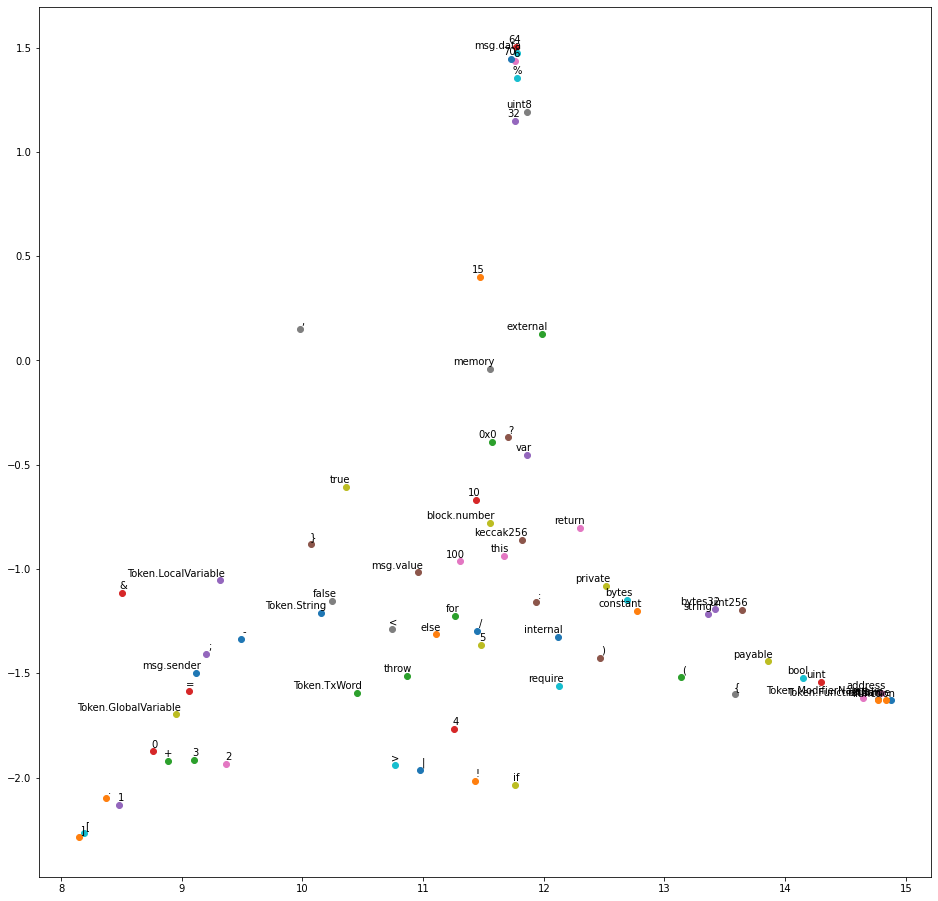

In [235]:
[functions, labels] = returnData(reentrancyContracts.contracts, reentrancyContractLabels.labels)
[w2v_mapping, fn_embeddings] = getFunctionEmbeddings(functions, length, token_dim)

tsne_plot(w2v_mapping)

# Models

In [19]:
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
from scipy.special import softmax
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle, class_weight
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, accuracy_score, f1_score, recall_score, precision_score

import tensorflow as tf
import keras.backend as K
from keras import layers, regularizers, Input
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Flatten, Embedding, Dropout, BatchNormalization
from keras.metrics import Accuracy, Precision, Recall

Using TensorFlow backend.


In [267]:
# compile formatted data and create splits
[functions, labels] = returnData(reentrancyContracts.contracts, reentrancyContractLabels.labels)
[w2v_mapping, X_train] = getFunctionEmbeddings(functions, 500, 15)

X = np.array(X_train)
y = np.array(labels)
X_train, y_train = shuffle(X[42:], y[42:])
X_test = X[:42]
y_test = y[:42]

In [268]:
print(X_train.shape)
print(y_train.shape)

(185, 500, 15)
(185,)


In [269]:
print(X_test.shape)
print(y_test.shape)

(42, 500, 15)
(42,)


In [270]:
def printResults(model, threshold):
    y_pred = model.predict(X_test)
    y_pred_eval = np.argmax(y_pred, axis=1)
    for i in range(len(y_pred)):
        val = 0
        if y_pred[i] > threshold: val = 1

        toPrint = "WRONG"
        if val == y_test[i]: toPrint = "correct"
        print(i, toPrint, ": ", val, " - ", y_pred[i][y_pred_eval[i]])

## BLSTM

In [178]:
blstm = Sequential()
blstm.add(Bidirectional(LSTM(50)))
blstm.add(Dense(10, activation='relu'))
blstm.add(Dense(1, activation='sigmoid'))

weights = class_weight.compute_class_weight('balanced', np.unique(y_test), y_train)

blstm.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print("Training...")
history = blstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, verbose=0)

Training...


In [179]:
print("Evaluate on train data")
results = blstm.evaluate(X_train, y_train)
print("train loss, train acc:", results)

Evaluate on train data
185/185 [==============================] - 0s 1ms/step
train loss, train acc: [0.33529613485207427, 0.816216230392456]


In [180]:
print("Evaluate on test data")
results = blstm.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
42/42 [==============================] - 0s 1ms/step
test loss, test acc: [0.26138320565223694, 0.9047619104385376]


In [181]:
y_pred = blstm.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

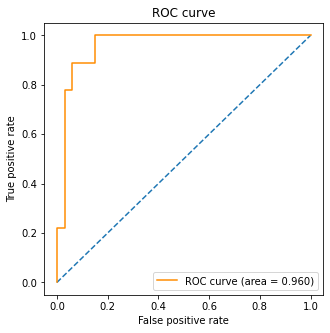

In [182]:
auc = roc_auc_score(y_test, y_pred)
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], '--')
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

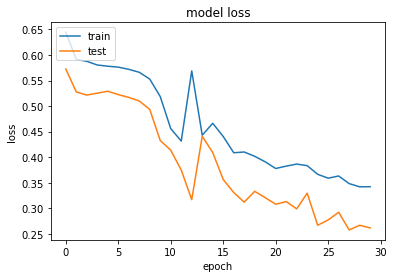

In [183]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [184]:
outputs = [1 if n >= 0.4 else 0 for n in y_pred]
print(classification_report(y_test, outputs))
print("F1 Score: ", f1_score(y_test, outputs, zero_division=1))
print("Recall Score: ", recall_score(y_test, outputs, zero_division=1))
print("Precision Score: ", precision_score(y_test, outputs, zero_division=1))
print("Accuracy Score: ", accuracy_score(y_test, outputs))

              precision    recall  f1-score   support

           0       0.97      0.85      0.90        33
           1       0.62      0.89      0.73         9

    accuracy                           0.86        42
   macro avg       0.79      0.87      0.82        42
weighted avg       0.89      0.86      0.87        42

F1 Score:  0.7272727272727274
Recall Score:  0.8888888888888888
Precision Score:  0.6153846153846154
Accuracy Score:  0.8571428571428571


In [203]:
# printResults(blstm, 0.5)

## CNN (baseline)

In [327]:
vocab_size = len(w2v_mapping.wv.vocab)
embedding_dim = 15
embeddings_per_example = 500

metrics = [
    Precision(name='precision'),
    Recall(name='recall')
]

weights = class_weight.compute_class_weight('balanced', np.unique(y_test), y_train)

cnn_1 = Sequential()
cnn_1.add(layers.Conv1D(128, 15, activation='relu'))
cnn_1.add(layers.GlobalMaxPooling1D())
cnn_1.add(layers.Dense(10, activation='relu'))
cnn_1.add(layers.Dense(1, activation='sigmoid'))

cnn_1.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'],
                class_weights=weights)

print("Training...")
history = cnn_1.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=30, epochs=250, verbose=0)

Training...


In [328]:
print("Evaluate on train data")
results = cnn_1.evaluate(X_train, y_train)
print("train loss, train acc:", results)

Evaluate on train data
185/185 [==============================] - 0s 314us/step
train loss, train acc: [0.0005074772990082164, 1.0]


In [329]:
print("Evaluate on test data")
results = cnn_1.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
42/42 [==============================] - 0s 240us/step
test loss, test acc: [0.27247193455696106, 0.9047619104385376]


In [330]:
y_pred = cnn_1.predict(X_test)
y_pred = (y_pred > 0.4)
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

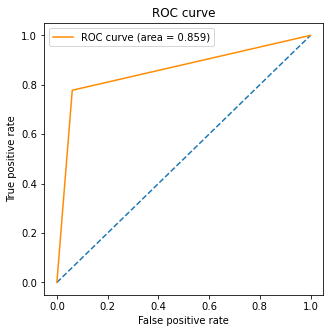

In [331]:
auc = roc_auc_score(y_test, y_pred)
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], '--')
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

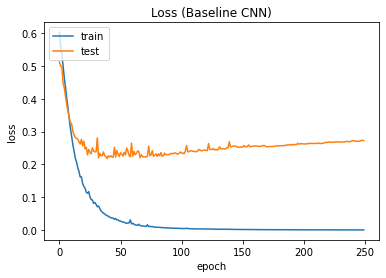

In [332]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss (Baseline CNN)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [333]:
outputs = [1 if n >= 0.4 else 0 for n in y_pred]
print(classification_report(y_test, outputs))
print("F1 Score: ", f1_score(y_test, outputs, zero_division=1))
print("Recall Score: ", recall_score(y_test, outputs, zero_division=1))
print("Precision Score: ", precision_score(y_test, outputs, zero_division=1))
print("Accuracy Score: ", accuracy_score(y_test, outputs))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        33
           1       0.78      0.78      0.78         9

    accuracy                           0.90        42
   macro avg       0.86      0.86      0.86        42
weighted avg       0.90      0.90      0.90        42

F1 Score:  0.7777777777777778
Recall Score:  0.7777777777777778
Precision Score:  0.7777777777777778
Accuracy Score:  0.9047619047619048


In [212]:
# printResults(cnn_1, 0.4)

## CNN (with dropout)

In [319]:
vocab_size = len(w2v_mapping.wv.vocab)
embedding_dim = 15
embeddings_per_example = 500

metrics = [
    Precision(name='precision'),
    Recall(name='recall')
]

weights = class_weight.compute_class_weight('balanced', np.unique(y_test), y_train)

cnn_drop = Sequential()
cnn_drop.add(layers.Conv1D(128, 15, activation='relu'))
cnn_drop.add(Dropout(0.6))
cnn_drop.add(layers.GlobalMaxPooling1D())
cnn_drop.add(layers.Dense(10, activation='relu'))
cnn_drop.add(Dropout(0.6))
cnn_drop.add(layers.Dense(1, activation='sigmoid'))

cnn_drop.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'],
                class_weights=weights)

print("Training...")
history = cnn_drop.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=30, epochs=250, verbose=0)

Training...


In [320]:
print("Evaluate on train data")
results = cnn_drop.evaluate(X_train, y_train)
print("train loss, train acc:", results)

Evaluate on train data
185/185 [==============================] - 0s 216us/step
train loss, train acc: [0.15777765762161564, 1.0]


In [321]:
print("Evaluate on test data")
results = cnn_drop.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
42/42 [==============================] - 0s 158us/step
test loss, test acc: [0.23538878560066223, 0.9523809552192688]


In [322]:
y_pred = cnn_drop.predict(X_test)
y_pred = (y_pred > 0.4)
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

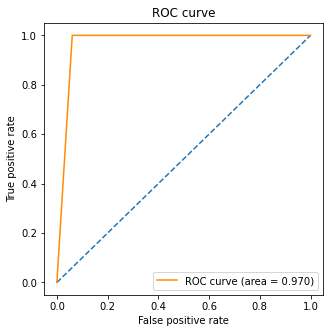

In [323]:
auc = roc_auc_score(y_test, y_pred)
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], '--')
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

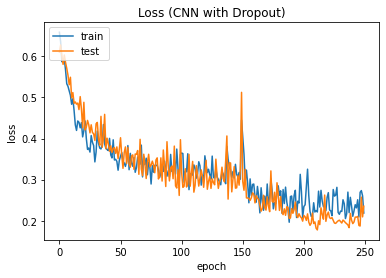

In [324]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss (CNN with Dropout)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [325]:
outputs = [1 if n >= 0.4 else 0 for n in y_pred]
print(classification_report(y_test, outputs))
print("F1 Score: ", f1_score(y_test, outputs, zero_division=1))
print("Recall Score: ", recall_score(y_test, outputs, zero_division=1))
print("Precision Score: ", precision_score(y_test, outputs, zero_division=1))
print("Accuracy Score: ", accuracy_score(y_test, outputs))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        33
           1       0.82      1.00      0.90         9

    accuracy                           0.95        42
   macro avg       0.91      0.97      0.93        42
weighted avg       0.96      0.95      0.95        42

F1 Score:  0.9
Recall Score:  1.0
Precision Score:  0.8181818181818182
Accuracy Score:  0.9523809523809523


In [334]:
# printResults(cnn_drop, 0.4)

## CNN (L2 regularization)

In [40]:
vocab_size = len(w2v_mapping.wv.vocab)
embedding_dim = 15
embeddings_per_example = 500

metrics = [
    Precision(name='precision'),
    Recall(name='recall')
]

weights = class_weight.compute_class_weight('balanced', np.unique(y_test), y_train)

cnn_l2 = Sequential()
cnn_l2.add(layers.Conv1D(128, 15, activation='relu'))
cnn_l2.add(layers.GlobalMaxPooling1D())
cnn_l2.add(layers.Dense(10, activation='relu', activity_regularizer=regularizers.l2(0.01)))
cnn_l2.add(layers.Dense(1, activation='sigmoid', activity_regularizer=regularizers.l2(0.01)))

cnn_l2.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'],
                class_weights=weights)

print("Training...")
history = cnn_l2.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=30, epochs=250, verbose=0)

Training...


In [41]:
print("Evaluate on train data")
results = cnn_l2.evaluate(X_train, y_train)
print("train loss, train acc:", results)

Evaluate on train data
185/185 [==============================] - 0s 230us/step
train loss, train acc: [0.4243375428625055, 0.7351351380348206]


In [42]:
print("Evaluate on test data")
results = cnn_l2.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
42/42 [==============================] - 0s 183us/step
test loss, test acc: [0.5090448260307312, 0.7857142686843872]


In [43]:
y_pred = cnn_l2.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

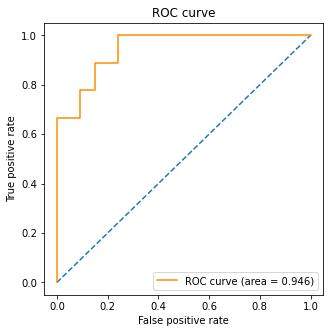

In [44]:
auc = roc_auc_score(y_test, y_pred)
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], '--')
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

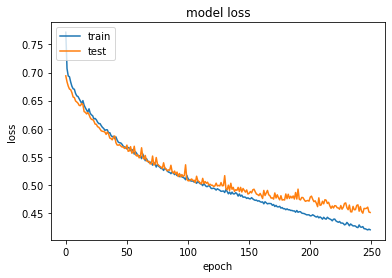

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [46]:
outputs = [1 if n >= 0.4 else 0 for n in y_pred]
print(classification_report(y_test, outputs))
print("F1 Score: ", f1_score(y_test, outputs, zero_division=1))
print("Recall Score: ", recall_score(y_test, outputs, zero_division=1))
print("Precision Score: ", precision_score(y_test, outputs, zero_division=1))
print("Accuracy Score: ", accuracy_score(y_test, outputs))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94        33
           1       1.00      0.56      0.71         9

    accuracy                           0.90        42
   macro avg       0.95      0.78      0.83        42
weighted avg       0.92      0.90      0.89        42

F1 Score:  0.7142857142857143
Recall Score:  0.5555555555555556
Precision Score:  1.0
Accuracy Score:  0.9047619047619048


In [47]:
# printResults(cnn_l2, 0.4)

## CNN (Added Conv1D Layer)

In [214]:
vocab_size = len(w2v_mapping.wv.vocab)
embedding_dim = 15
embeddings_per_example = 500

metrics = [
    Precision(name='precision'),
    Recall(name='recall')
]

weights = class_weight.compute_class_weight('balanced', np.unique(y_test), y_train)

twolayer_cnn = Sequential()
twolayer_cnn.add(layers.Conv1D(128, 10, activation='relu'))
twolayer_cnn.add(layers.Conv1D(64, 10, activation='relu'))
twolayer_cnn.add(layers.GlobalMaxPooling1D())
twolayer_cnn.add(layers.Dense(10, activation='relu'))
twolayer_cnn.add(layers.Dense(1, activation='sigmoid'))

twolayer_cnn.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'],
                class_weights=weights)

print("Training...")
history = twolayer_cnn.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=30, epochs=150, verbose=0)

Training...


In [215]:
print("Evaluate on train data")
results = twolayer_cnn.evaluate(X_train, y_train)
print("train loss, train acc:", results)

Evaluate on train data
185/185 [==============================] - 0s 318us/step
train loss, train acc: [0.000440299732459558, 1.0]


In [216]:
print("Evaluate on test data")
results = twolayer_cnn.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
42/42 [==============================] - 0s 272us/step
test loss, test acc: [0.4246232509613037, 0.8571428656578064]


In [217]:
y_pred = twolayer_cnn.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

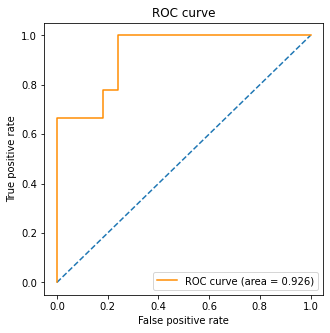

In [218]:
auc = roc_auc_score(y_test, y_pred)
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], '--')
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

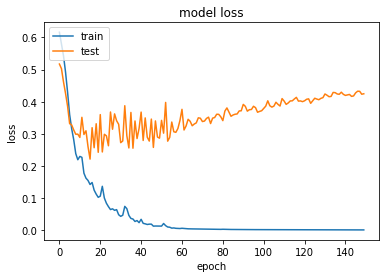

In [219]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [220]:
outputs = [1 if n >= 0.4 else 0 for n in y_pred]
print(classification_report(y_test, outputs))
print("F1 Score: ", f1_score(y_test, outputs, zero_division=1))
print("Recall Score: ", recall_score(y_test, outputs, zero_division=1))
print("Precision Score: ", precision_score(y_test, outputs, zero_division=1))
print("Accuracy Score: ", accuracy_score(y_test, outputs))

              precision    recall  f1-score   support

           0       0.90      0.85      0.88        33
           1       0.55      0.67      0.60         9

    accuracy                           0.81        42
   macro avg       0.72      0.76      0.74        42
weighted avg       0.83      0.81      0.82        42

F1 Score:  0.6
Recall Score:  0.6666666666666666
Precision Score:  0.5454545454545454
Accuracy Score:  0.8095238095238095


In [221]:
# printResults(twolayer_cnn, 0.4)

## CNN (higher positive class weight)

In [222]:
vocab_size = len(w2v_mapping.wv.vocab)
embedding_dim = 15
embeddings_per_example = 500

metrics = [
    Precision(name='precision'),
    Recall(name='recall')
]

weights = [.65, 2.5]

cnn_hweights = Sequential()
cnn_hweights.add(layers.Conv1D(128, 15, activation='relu'))
cnn_hweights.add(layers.GlobalMaxPooling1D())
cnn_hweights.add(layers.Dense(10, activation='relu'))
cnn_hweights.add(layers.Dense(1, activation='sigmoid'))

cnn_hweights.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'],
                class_weights=weights)

print("Training...")
history = cnn_hweights.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=30, epochs=300, verbose=0)

Training...


In [223]:
weights

[0.65, 2.5]

In [224]:
print("Evaluate on train data")
results = cnn_hweights.evaluate(X_train, y_train)
print("train loss, train acc:", results)

Evaluate on train data
185/185 [==============================] - 0s 202us/step
train loss, train acc: [0.00042395328039404107, 1.0]


In [225]:
print("Evaluate on test data")
results = cnn_hweights.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
42/42 [==============================] - 0s 144us/step
test loss, test acc: [0.2165490984916687, 0.9285714030265808]


In [226]:
y_pred = cnn_hweights.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

In [227]:
auc = roc_auc_score(y_test, y_pred)
print('AUC: %.3f' % auc)

AUC: 0.963


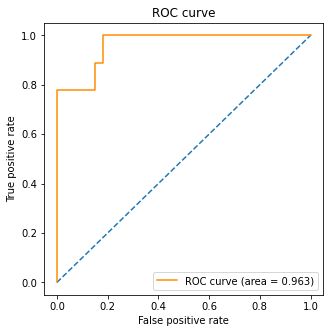

In [228]:
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], '--')
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

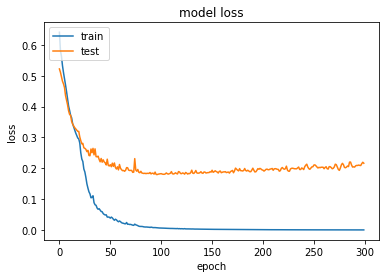

In [229]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [230]:
outputs = [1 if n >= 0.4 else 0 for n in y_pred]
print(classification_report(y_test, outputs))
print("F1 Score: ", f1_score(y_test, outputs, zero_division=1))
print("Recall Score: ", recall_score(y_test, outputs, zero_division=1))
print("Precision Score: ", precision_score(y_test, outputs, zero_division=1))
print("Accuracy Score: ", accuracy_score(y_test, outputs))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        33
           1       1.00      0.67      0.80         9

    accuracy                           0.93        42
   macro avg       0.96      0.83      0.88        42
weighted avg       0.93      0.93      0.92        42

F1 Score:  0.8
Recall Score:  0.6666666666666666
Precision Score:  1.0
Accuracy Score:  0.9285714285714286


In [557]:
# printResults(cnn_hweights, 0.4)